# Semantic Projection

Python implementation of methodology published in **Semantic projection recovers rich human knowledge of multiple object features from word embeddings** (by Gabriel Grand, Idan Asher Blank, Francisco Pereira & Evelina Fedorenko). 

Notebook written by Kathleen Esfahany (kaes@mit.edu).


In [2]:
import numpy as np

## Load GloVe Model
Download GloVe here: https://nlp.stanford.edu/projects/glove/

In [3]:
def loadGloveModel(filepath):
    f = open(filepath,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    return model

glove_filepath_42B ="./GloVe_42B/glove.42B.300d.txt"

GloVe_Model_42B = loadGloveModel(glove_filepath_42B) # dict w/ words as keys and values as vectors (takes about 3 minutes)

In [4]:
def glove(input_list):
    """
    Returns 300d GloVe vector corresponding to word(s)
    """
    return [GloVe_Model_42B[word] for word in input_list]

## Generate Feature Vector

####  (excerpt from the paper) Defining feature subspaces
A one-dimensional feature subspace is approximated by the vector difference between antonyms that represent opposite ends of the feature continuum. In our implementation, each end was represented by three words similar in meaning that were chosen by the authors based on intuition from amongst the words used as cues in the word association study in ref. 122. For instance, for the feature ‘danger’, one end was represented by the three vectors {dangerous,deadly, threatening}, and the other end by the three vectors {safe,harmless,calm}. The feature subspace was then defined as the average of the 3 × 3 = 9 possible vector differences (or ‘lines’) between the two ends. Onto this subspace, we projected the word-vectors of all category items.

In [5]:
def get_feature_vector(a, b):
    """
    a: list of length n of words on one end of the feature continuum
    b: list of length m of words on the other end of the continuum

    example:
    get_feature_vector(["small", "litte", "tiny"], ["large", "big", "huge"])
    
    """

    # generate list of GloVe embeddings for each end of continuum
    A = glove(a)
    B = glove(b)

    # generate the n x m possible vector differences ("lines") between the two ends
    lines = [] # will be a (n x m, 300) matrix
    for A_i in A:
        for B_j in B:
            lines.append(B_j - A_i)

    # generate the average of the n x m differences
    feature_vector = np.mean(np.array(lines), axis = 0) # shape (300,)
    return feature_vector

## Project words onto feature subspace
https://en.wikipedia.org/wiki/Vector_projection

In [6]:
def get_orthogonal_projection(u, v):
    """
    Project vector u on vector v
    """
    projection = (np.dot(u, v)/np.dot(v, v)) * v
    return projection

def get_word_projections(words, feature_set_1, feature_set_2):
    """
    All params are lists of strings 

    example:
    get_word_projection(["mouse", "elephant"],["small", "litte", "tiny"], ["large", "big", "huge"])

    """
    # get GloVe embeddings of words
    word_embeddings = glove(words)

    # get feature subspace
    feature_vector = get_feature_vector(feature_set_1, feature_set_2)

    word_projections = [get_orthogonal_projection(word, feature_vector) for word in word_embeddings]

    return word_projections


## Ranking words along a feature space

In [7]:
def get_projection_score(u, v):
    """
    Get a scalar magnitude of u on v
    """
    projection_score = (np.dot(u, v)/np.dot(v, v))
    return projection_score

def get_scores(words, feature_set_1, feature_set_2):
    """
    
    get_scores(["mouse", "elephant"],["small", "litte", "tiny"], ["large", "big", "huge"])

    """
    # get GloVe embeddings of words
    word_embeddings = glove(words)

    # get feature subspace
    feature_vector = get_feature_vector(feature_set_1, feature_set_2)

    # get projection scores
    projection_scores = [get_projection_score(word, feature_vector) for word in word_embeddings]

    return projection_scores

def get_rankings(words, feature_set_1, feature_set_2):
    """
    All params are lists of strings 

    Ranks words on an axis from feature 1 to feature 2

    example:
    get_rankings(["mouse", "elephant"],["small", "litte", "tiny"], ["large", "big", "huge"])

    """
    # get projection scores
    projection_scores = get_scores(words, feature_set_1, feature_set_2)

    # order the words by rank
    ranks = np.argsort(projection_scores)

    return ranks

def order_words_along_feature(words, feature_set_1, feature_set_2):
    """
    Return a list of words ordered along feature axis
    """
    ranks = get_rankings(words, feature_set_1, feature_set_2)
    return list(np.array(words)[ranks])

In [9]:
# example
words = ["mouse", "elephant", "whale", "ant"]
feature_1 = ["small", "litte", "tiny"]
feature_2 = ["large", "big", "huge"]
order_words_along_feature(words, feature_1, feature_2)


['mouse', 'ant', 'whale', 'elephant']

# Larger-scale example from paper

In [10]:
animal_category = "Alligator, Ant, Bee, Bird, Butterfly, Camel, Cheetah, Chicken, Chipmunk, Crow, Dog, Dolphin, Duck, Elephant, Goldfish, Hamster, Hawk, Horse, Mammoth, Monkey, Moose, Mosquito, Mouse, Orca, Penguin, Pig, Rhino, Salmon, Seal, Snake, Swordfish, Tiger, Turtle, Whale"
animal_list = [word.lower() for word in animal_category.split(", ")] 
feature_1 = ["small", "litte", "tiny"]
feature_2 = ["large", "big", "huge"]
semantic_projection_scores = get_scores(animal_list, feature_1, feature_2)

# generate n = 1 human rankings (by me)
human_ordering = "Mosquito Ant Bee Butterfly Goldfish Mouse Hamster Chipmunk Turtle Bird Crow Chicken Duck Salmon Hawk Dog Penguin Snake Pig Monkey Swordfish Seal Alligator Dolphin Cheetah Tiger Camel Horse Rhino Moose Elephant Mammoth Orca Whale"
human_ordering_list = [word.lower() for word in human_ordering.split()]
human_ranking = np.argsort(human_ordering_list) # (ranks wrt original alphabetical animal list)

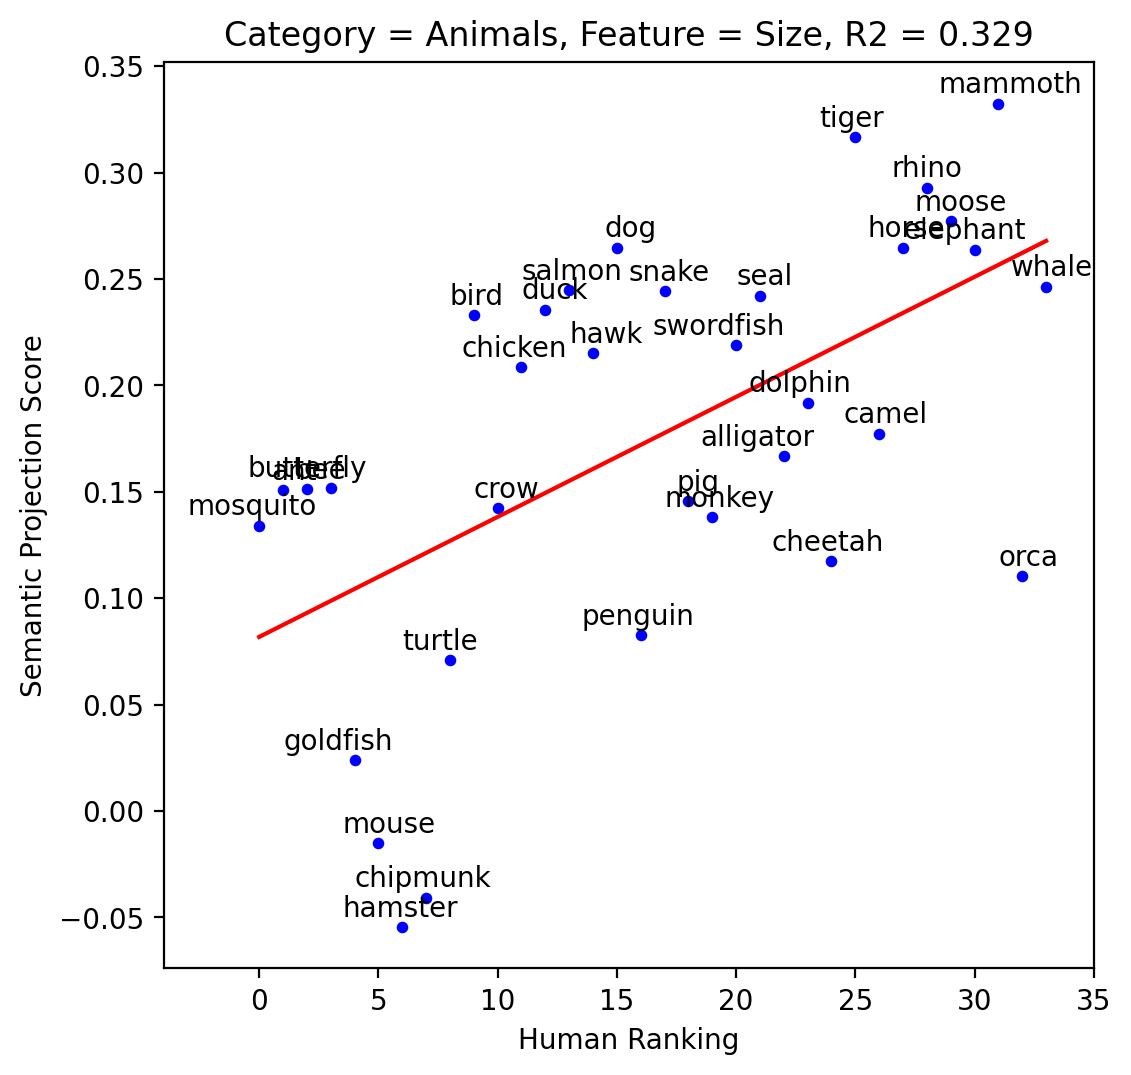

In [12]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# regress semantic projection scores on human rankings using OLS
model = sm.OLS(semantic_projection_scores, sm.add_constant(human_ranking))
result = model.fit()
x_input = np.arange(0, len(animal_list))
y_hat = result.predict(sm.add_constant(x_input))

plt.figure(figsize=(6, 6), dpi=200)
plt.plot(x_input, y_hat, color = "red") # plot regression
plt.scatter(human_ranking, semantic_projection_scores, s = 10, color = "blue") # scatter point for each animal
for i in range(len(animal_list)):
    x = human_ranking[i]
    y = semantic_projection_scores[i]
    s = animal_list[i]
    plt.text(x+1-(len(s)/2), y+0.005, s) # text label for each animal
plt.xlim(-4, 35)
plt.xlabel("Human Ranking")
plt.ylabel("Semantic Projection Score")
plt.title(f"Category = Animals, Feature = Size, R2 = {np.round(result.rsquared, 3)}")
plt.show()
